[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/validation.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Choosing the appropriate model complexity

Choosing the appropriate model complexity is crucial to obtain a good performance. A model that is too simple will not be able to capture the underlying patterns in the data, (underfitting) while a model that is too complex will capture noise in the data and will not generalize well to new data (overfitting). In this notewbook, we will see how to choose the appropriate model complexity using three datasets: training, validation (development), and test sets. We will use a polynomial regression model to illustrate the concept of model complexity.

In [28]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/regression'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

# import the required modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Ground truth function

We define a secret polynomial function of degree 3 to generate the dataset. It is the function to be learned by the model from the data (in real problems, this function is unknown). 

In [29]:

# Generate the dataset from a secret polynomial function
def generate_dataset(n_samples: int, random_state: int, from_value: float, to_value: float) -> tuple[pd.DataFrame, np.array]:
    """
    Generate a dataset with n_samples samples for a secret polynomial function.
    The function is $y = 3.1x^3 + 2.2x^2 + 1.1x + 5.5$.
    :param n_samples: number of samples to generate
    :param random_state: random seed
    :param from_value: minimum value of the domain
    :param to_value: maximum value of the domain
    :return: (pandas dataset with 'x' and 'y' features, ground truth)
    """
    np.random.seed(random_state)
    x_values = np.linspace(from_value, to_value, n_samples)
    # Ground truth polynomial function of degree 3
    y_truth = 3.1 * x_values ** 3 + 2.2 * x_values ** 2 + 1.1 * x_values + 5.5
    # Add Gaussian noise
    y_values = y_truth + np.random.normal(0, 100, n_samples)
    return pd.DataFrame({'x': x_values, 'y': y_values}), y_truth

## Dataset

Let's generate the dataset and split it into training, validation, and test sets. First, we generate the dataset with 1000 samples. Then, we split the dataset into training (80%) and test (20%) sets. Then, we split the training set into training (75%) and validation (25%) sets. Thus, the final dataset is divided into 60% training (0.75x0.8), 20% validation (0.25x0.8), and 20% test sets.

In [30]:
# values of the domain
from_value, to_value = -10, 10
dataset, y_truth = generate_dataset(1000, random_state, from_value, to_value)
# Split the dataset into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset[['x']], dataset['y'], test_size=0.2,
                                                            random_state=random_state)
# Split the train dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,
                                                  random_state=random_state)  # 0.25 * 0.8 = 0.2

## Model complexity and performance

We will train polynomial regression models with different degrees and evaluate their performance on the training and validation sets. *Important*: we never use the test set. We will use the mean squared error (MSE) to evaluate the performance of the models. 

We first define a function to visually show the performance of the models on the training set.

In [31]:
def plot_model(model: LinearRegression, degree: int, X_train_p: pd.DataFrame, y_train_p: pd.DataFrame, y_truth_p: np.ndarray, 
               from_value_p: float, to_value_p: float, poly_features_p: PolynomialFeatures) -> None:
    """
    Function to plot a polynomial regression model (scatter plot) and compare it to the ground truth (plot).
    :param model: polynomial regression model
    :param degree: degree of the polynomial
    :param X_train_p: independent variable of the training set
    :param y_train_p: dependent variable of the training set
    :param y_truth_p: ground truth of the dataset (actual values of the dependent variable)
    :param from_value_p: minimum value of the domain
    :param to_value_p: maximum value of the domain
    :param poly_features_p: polynomial features    
    """
    plt.figure(figsize=(14, 8))
    plt.scatter(X_train_p, y_train_p, color='gray', alpha=0.5, label='Training data')
    plt.plot(dataset['x'], y_truth_p, color='red', label='Ground truth (degree 3)')
    X_plot = np.linspace(from_value_p, to_value_p, 100).reshape(-1, 1)
    X_plot_poly = poly_features_p.transform(X_plot)
    y_plot_pred = model.predict(X_plot_poly)
    plt.plot(X_plot, y_plot_pred, linestyle='--', label=f'Polynomial degree {degree}')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Polynomial Regression Model (degree {degree})')
    plt.legend()
    plt.show()

Now, we train polynomial regression models with different degrees (complexity levels). We evaluate the models on the validation set and store the best model (the one with the lowest MSE). We also plot the models to visually compare them to the ground truth.

Degree:   1, Validation MSE:    236643.45


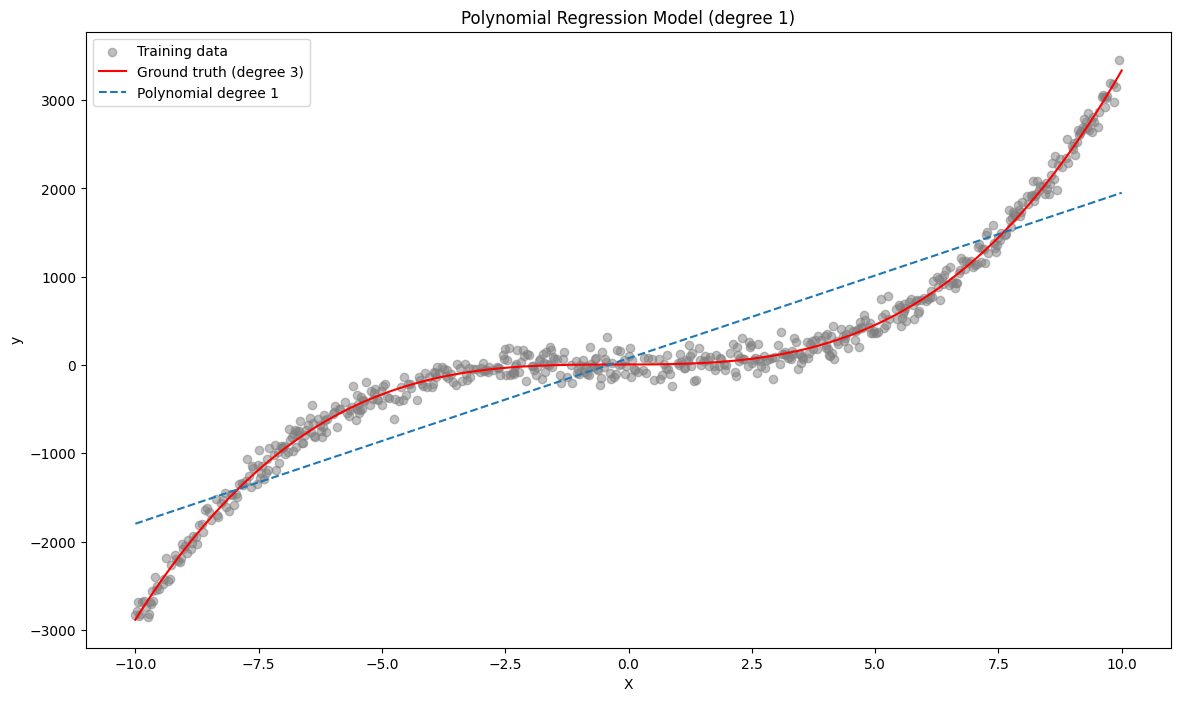

Degree:   2, Validation MSE:    237767.12


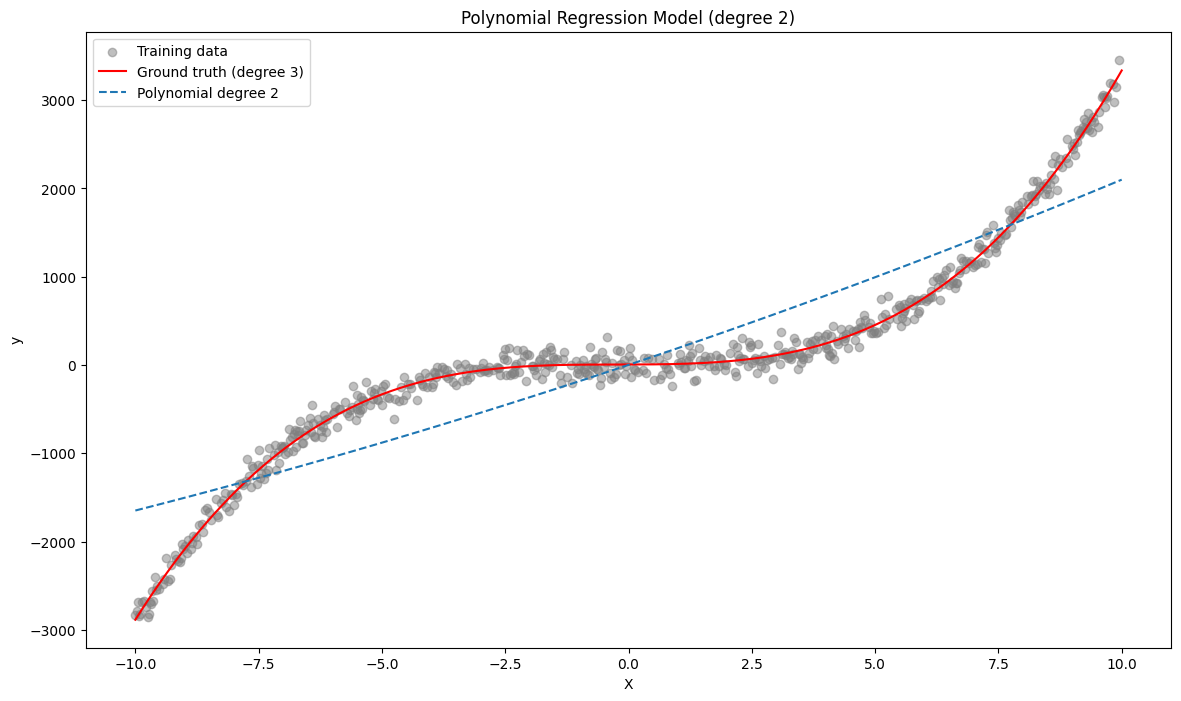

Degree:   3, Validation MSE:      9295.41


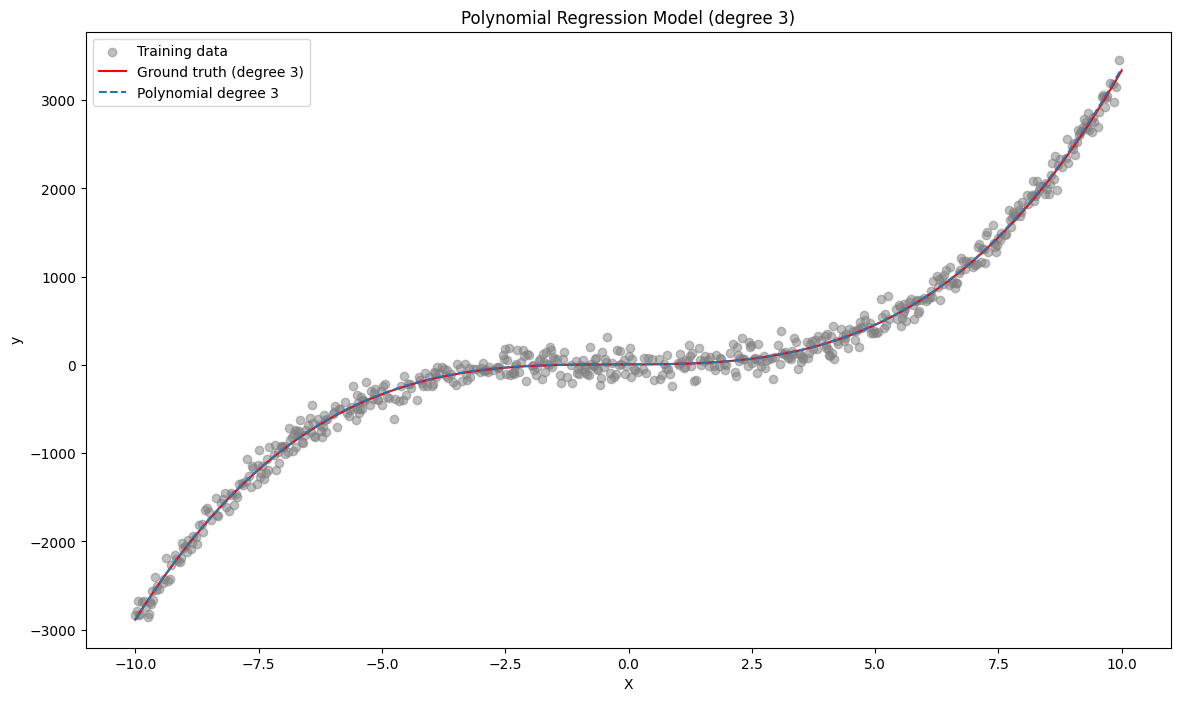

Degree:   4, Validation MSE:      9225.45


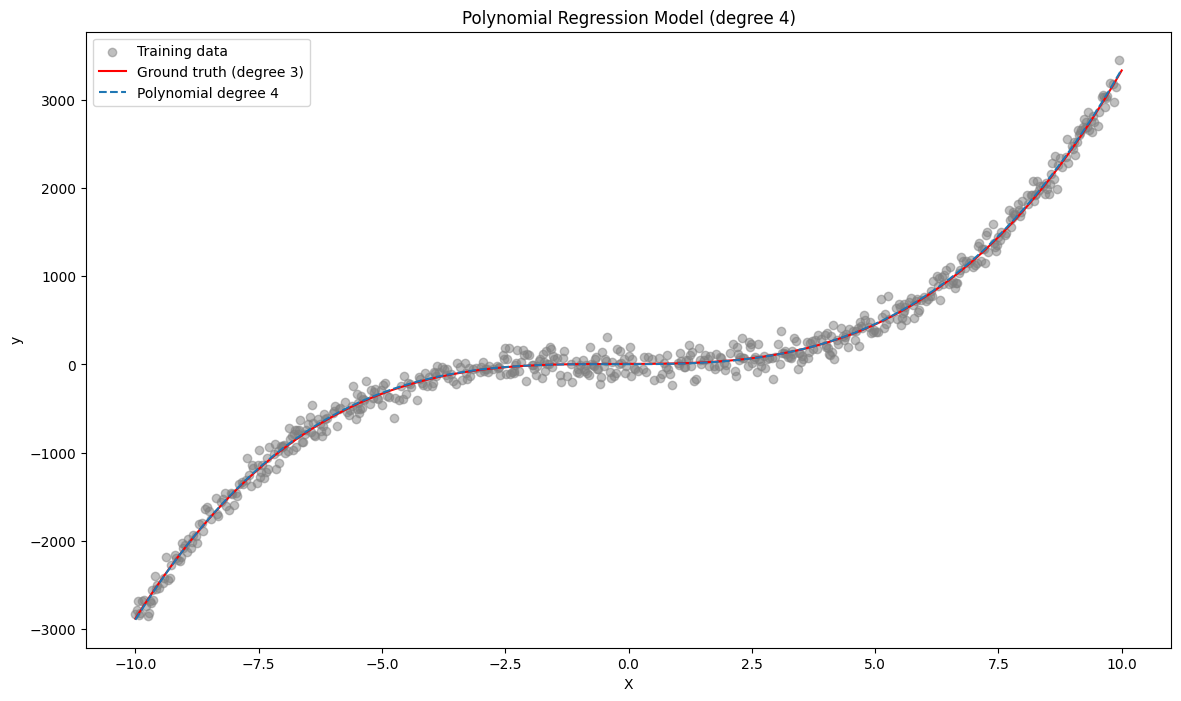

Degree:   5, Validation MSE:      9251.77


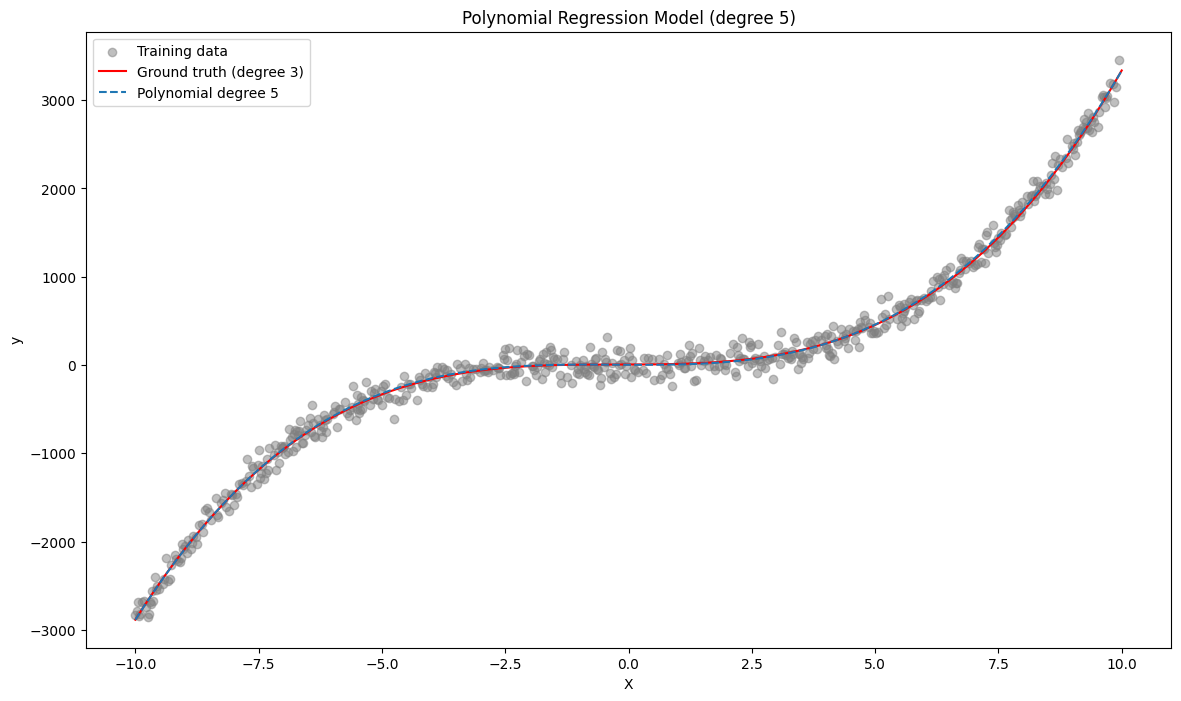

Degree:   6, Validation MSE:      9374.23


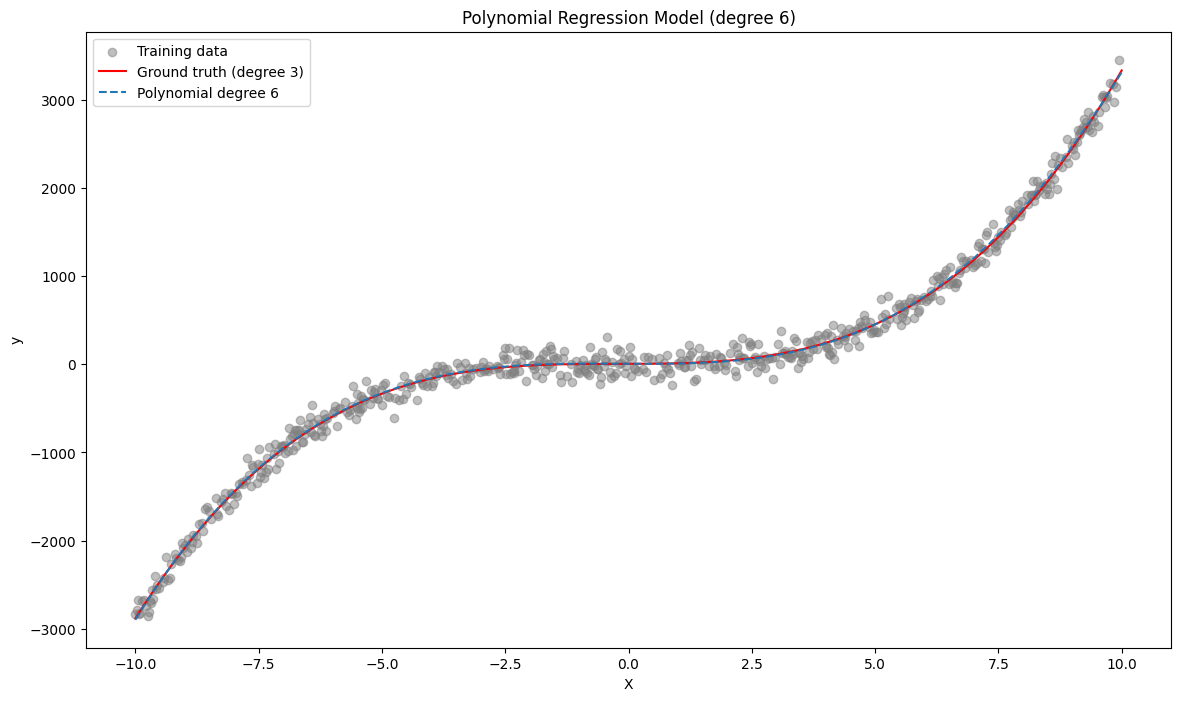

Degree:   7, Validation MSE:      9358.67


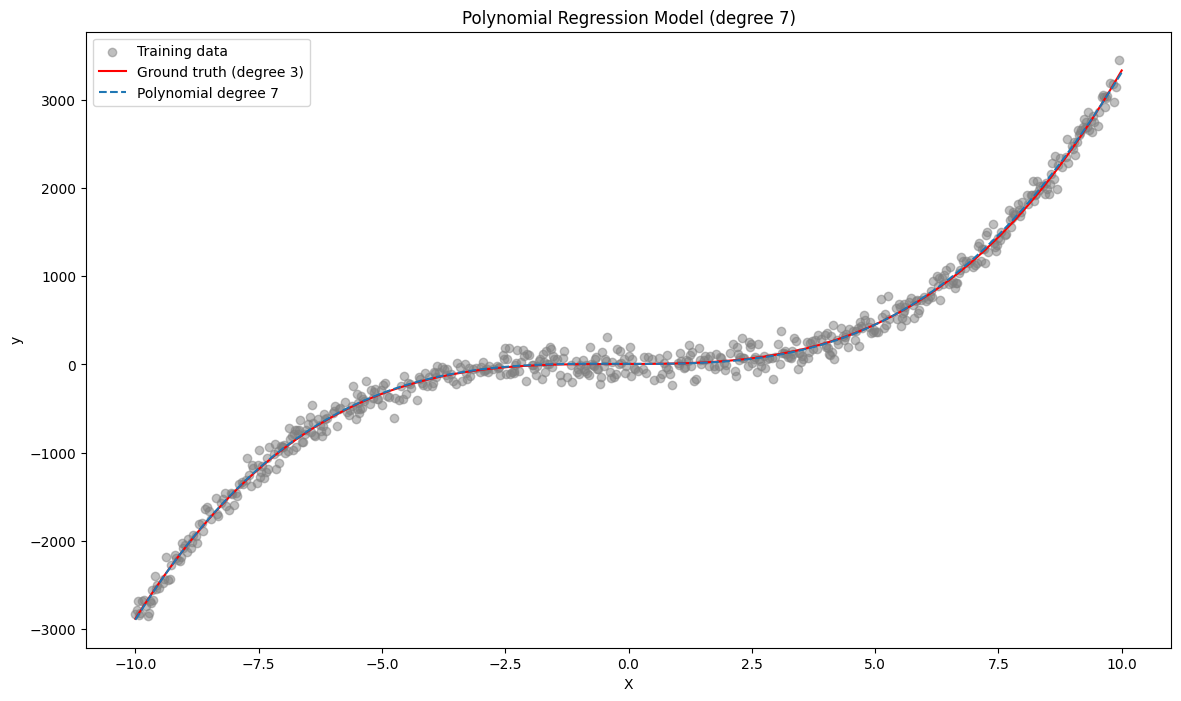

Degree:   8, Validation MSE:      9343.22


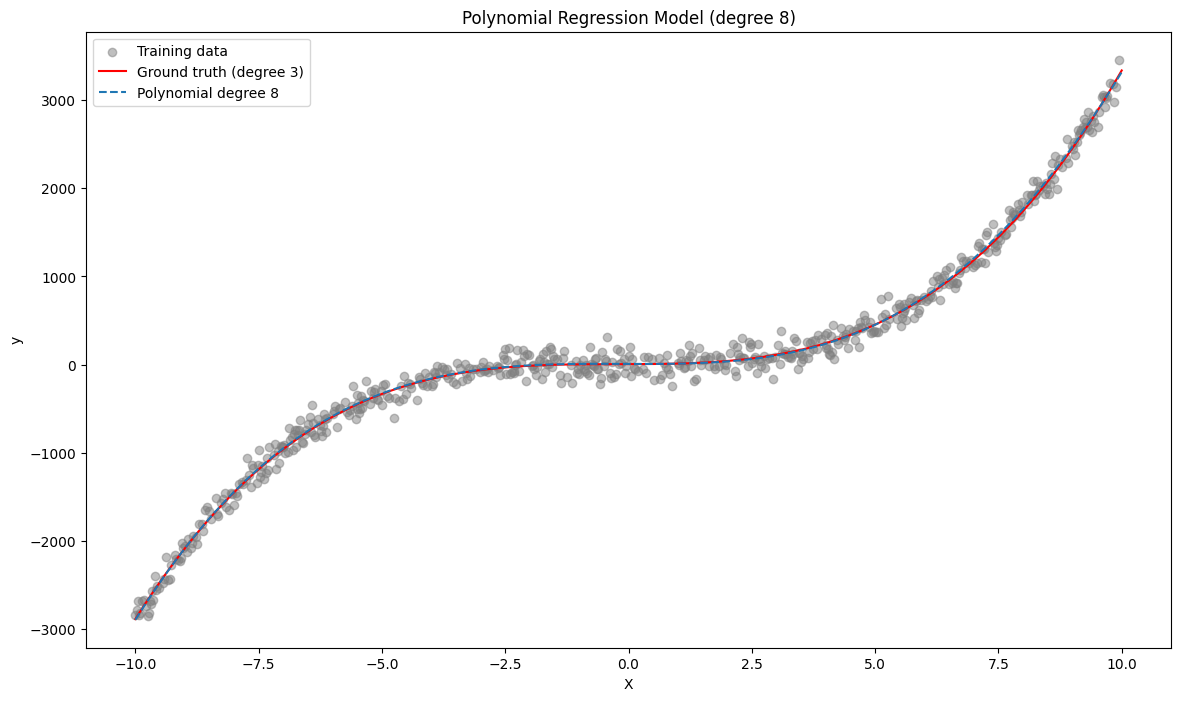

Degree:   9, Validation MSE:      9377.81


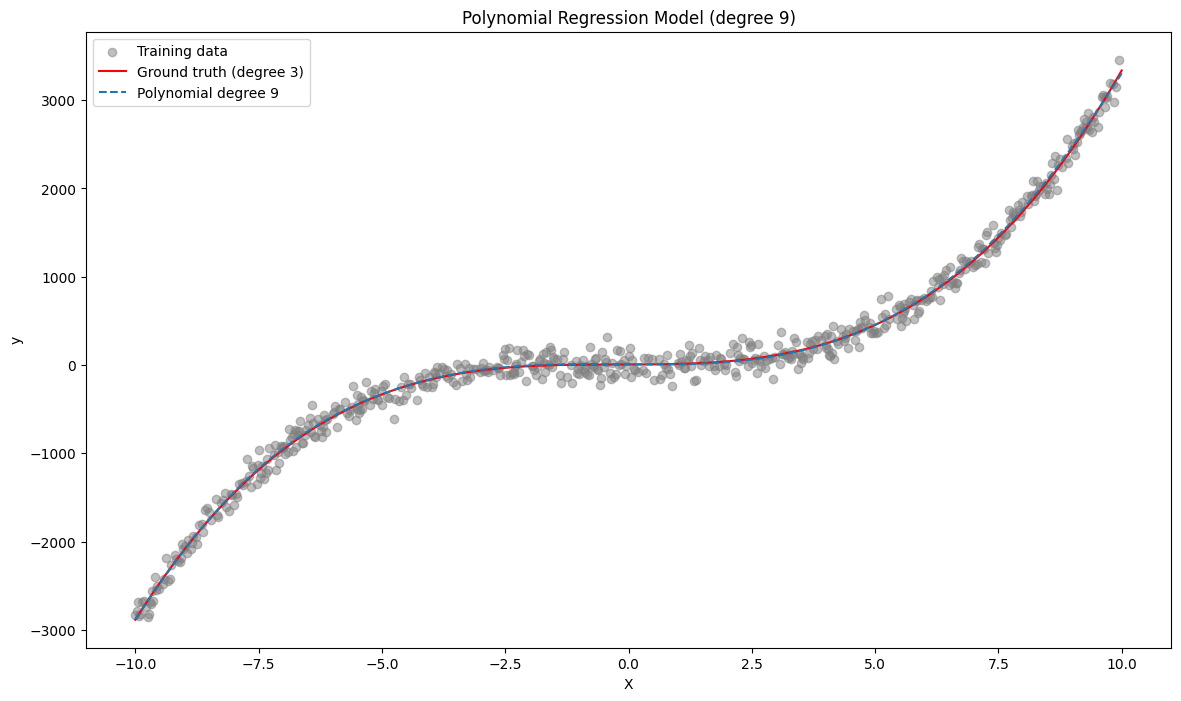

Degree:  10, Validation MSE:      9350.82


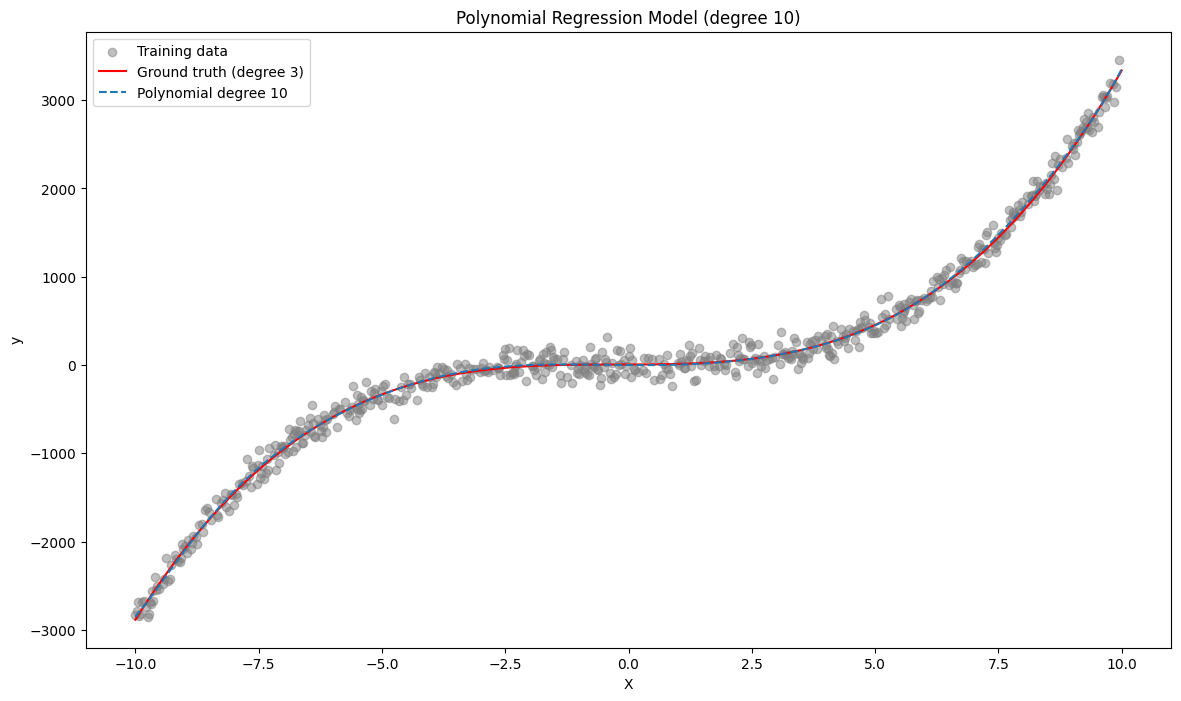

Degree:  20, Validation MSE:     12283.12


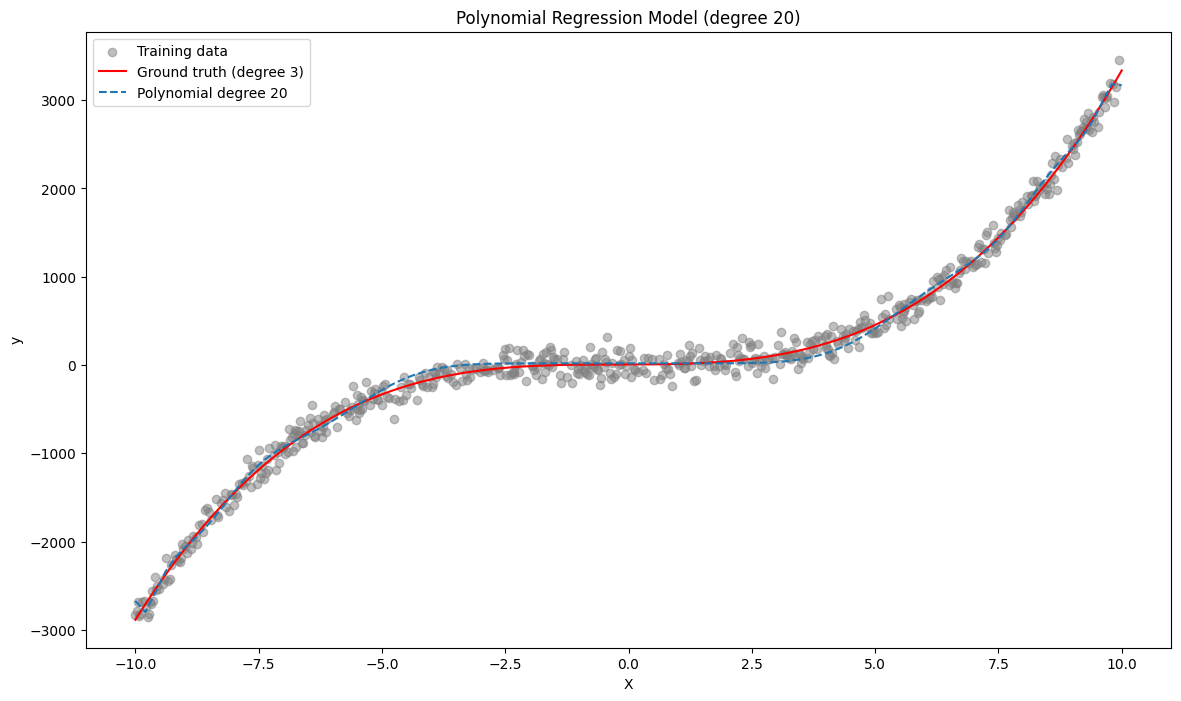

Degree:  50, Validation MSE:    593176.78


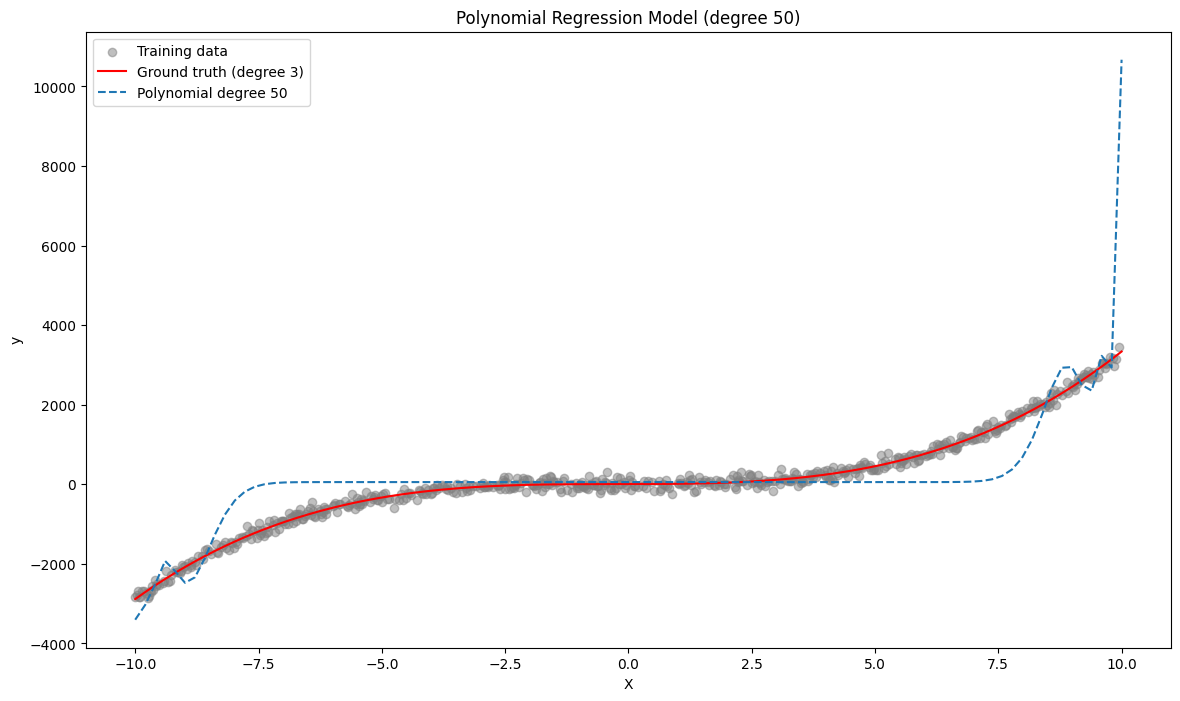

Degree: 100, Validation MSE:  13522622.81


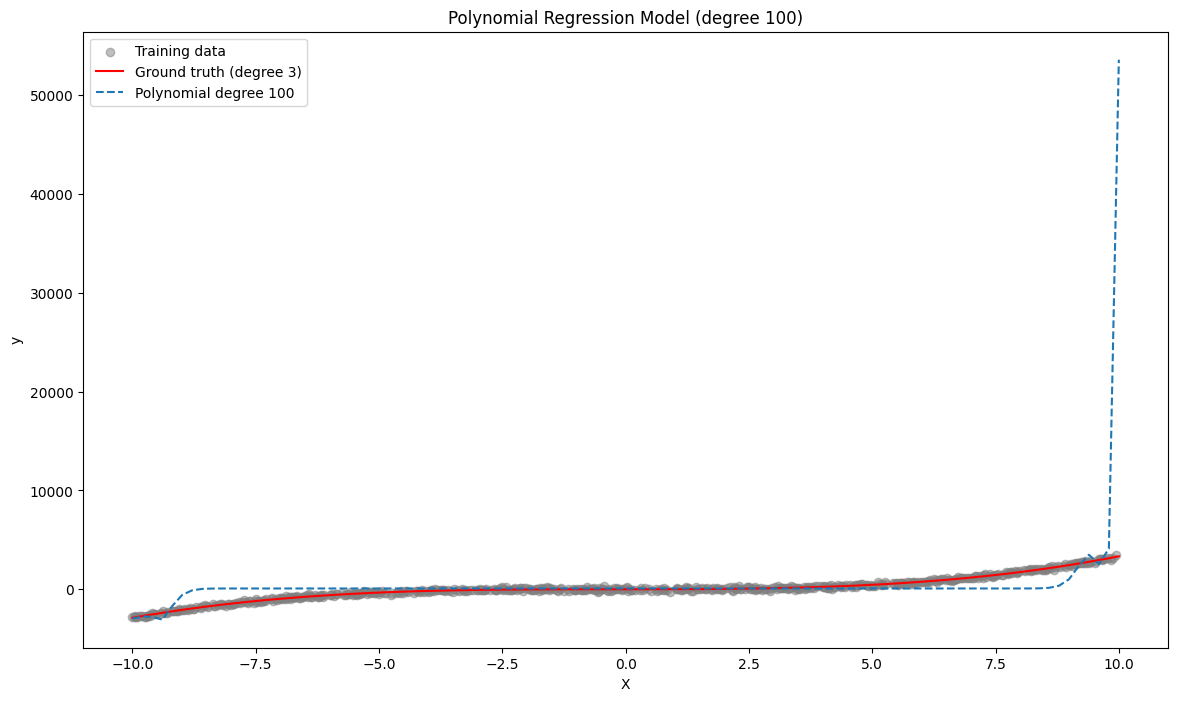

In [32]:
# Train polynomial regression models with different degrees
degrees = list(range(1, 11)) + [20, 50, 100]
best_degree = 0
best_mse = float('inf')
best_model = None

for degree in degrees:
    # Create the polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train.values)
    X_val_poly = poly_features.transform(X_val.values)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val_poly)
    mse = mean_squared_error(y_val, y_val_pred)

    print(f'Degree: {degree:3}, Validation MSE: {mse:12.2f}')

    plot_model(model, degree, X_train, y_train, y_truth, from_value, to_value, poly_features)

    if mse < best_mse:
        best_mse = mse
        best_degree = degree
        best_model = model

## Model evaluation

Finally, we evaluate the best model on the test set. We also plot the model to compare it to the ground truth.

Best degree: 4.
Test MSE: 9485.4243.


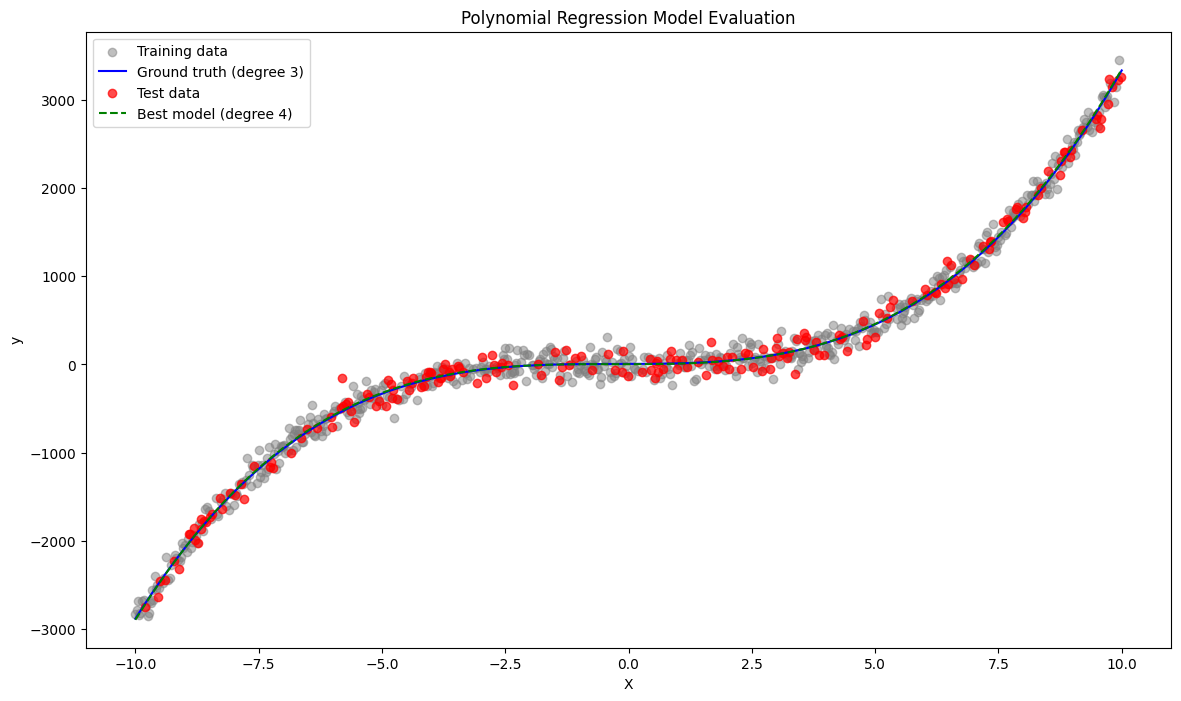

In [33]:
# Evaluate the best model on the test set
poly_features_best = PolynomialFeatures(degree=best_degree)
X_test_poly = poly_features_best.fit_transform(X_test.values)
y_test_pred = best_model.predict(X_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
# print the results
print(f'Best degree: {best_degree}.')
print(f'Test MSE: {test_mse:.4f}.')


# plot the results; similar to the plot_model function, but including the test set
def plot_results(X_train_p: pd.DataFrame, y_train_p: pd.Series, y_truth: np.ndarray, X_test_p: pd.DataFrame, y_test_p: pd.Series, best_model_p: LinearRegression, 
                 best_degree_p: int) -> None:
    """
    Plot the results of the polynomial regression model, showing the training, test, and ground truth data.
    :param X_train_p: independent variable of the training set
    :param y_train_p: dependent variable of the training set
    :param y_truth: ground truth of the dataset (actual values of the dependent variable)
    :param X_test_p: independent variable of the test set
    :param y_test_p: dependent variable of the test set
    :param best_model_p: best polynomial regression model
    :param best_degree_p: degree of the best polynomial regression model    
    """
    plt.figure(figsize=(14, 8))
    plt.scatter(X_train_p, y_train_p, color='gray', alpha=0.5, label='Training data')
    plt.plot(dataset['x'], y_truth, color='blue', label='Ground truth (degree 3)')
    plt.scatter(X_test_p, y_test_p, color='red', alpha=0.7, label='Test data')
    # Plot the best model's predictions
    X_plot = np.linspace(-10, 10, 100).reshape(-1, 1)
    X_plot_poly = poly_features_best.transform(X_plot)
    y_plot_pred = best_model_p.predict(X_plot_poly)
    plt.plot(X_plot, y_plot_pred, color='green', linestyle='--', label=f'Best model (degree {best_degree_p})')
    # labels and legend
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Polynomial Regression Model Evaluation')
    plt.legend()
    plt.show()

plot_results(X_train, y_train, y_truth, X_test, y_test, best_model, best_degree)

## ✨ Questions ✨

1. What is the best degree for the polynomial regression model?
2. Does the degree coincide with the degree of the ground truth polynomial function? Why?
3. What happens for degrees 1 and 2?
4. What happens for degrees 50, and 100?
5. Is the test MSE higher or lower than the validation MSE? Why?
6. What do you learn from this last question?


### Answers

*Write your answers here.*
